In [1]:
# outdate see other 732 script
import numpy as np
import pandas as pd

In [2]:
import sklearn
sklearn.__version__

'0.23.1'

In [3]:
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
rc={'font.size': 12, 'axes.labelsize': 12, 'figure.dpi':300,
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12} # 'figure.figsize':(11.7/1.5,8.27/1.5)
flatui = ["#5cb85c", "#337ab7", "#f0ad4e", "#d9534f"]#["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set(style='ticks',rc=rc)
sns.palplot(sns.color_palette(flatui))

/Users/yong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# print sns version
sns.__version__

'0.9.0'

In [5]:
matplotlib.__version__

'3.2.2'

In [6]:
# load data
sel_lipid_df = pd.read_csv('f_data/train_norm_sel_lipid_df_mi_108.csv', sep='\t')
sel_metabolic_df = pd.read_csv('f_data/train_norm_sel_metabolic_df_mi_108.csv', sep='\t')
sel_protein_df = pd.read_csv('f_data/train_norm_sel_protein_df_mi_108.csv', sep='\t')
sel_mrna_df = pd.read_csv('f_data/train_norm_sel_mrna_df_mi_108.csv', sep='\t')

In [7]:
sel_lipid_df.shape[1]-2,sel_metabolic_df.shape[1]-2, sel_protein_df.shape[1]-2, sel_mrna_df.shape[1]-2


(42, 64, 98, 93)

In [8]:
from functools import reduce
data_frames = [sel_lipid_df, sel_metabolic_df, sel_protein_df, sel_mrna_df]

comb_df = reduce(lambda  left,right: pd.merge(left,right,on=['label','pat_id'],
                                            how='inner'), data_frames)

In [9]:
y_train = comb_df['label']
X_train = comb_df.drop(columns=['label','pat_id'])

In [10]:
X_train.shape

(108, 297)

In [11]:
def get_class_weight(y_train):
    
    from sklearn.utils.class_weight import compute_class_weight
    cls = np.unique(y_train)
    cls_weight = compute_class_weight('balanced', cls, y_train)
    class_weight_dict = dict(zip(cls, cls_weight))
    return class_weight_dict



In [12]:
import xgboost as xgb # direct xgboost library
from xgboost.sklearn import XGBClassifier # sklearn wrapper   
from sklearn.model_selection import GridSearchCV 

In [13]:
init_est = XGBClassifier(learning_rate =0.3, # this is analogue to eta, Typical: 0.01-0.2
                         n_estimators=260, # the number of iterations/trees.  
                         max_depth=5, # Typical values: 3-10 
                         min_child_weight=1,
                         gamma=0, # min_split_loss
                         subsample=0.8, # the fraction of observations to be randomly samples for each tree. 0.5-1
                         colsample_bytree=0.8, # the fraction of columns to be randomly samples for each tree. 0.5-1
                         objective= 'multi:softprob', 
                         reg_alpha = 0.01,
                         seed=123, early_stopping_rounds=50,n_jobs=-1)


'''
Tune hyperparameters 
'''
def xgb_train_cv(x_train, y_train, init_estimator = init_est, n_folds = 5, scoring = 'recall'):
    
    import warnings
    warnings.filterwarnings("ignore")
    
    param_groups = {
        '1':{ # 1. Tune max_depth and min_child_weight
            'max_depth': range(8,16),
            'min_child_weight':range(1,4)
        },
        '2':{ # 2. Tune gamma
            'gamma':[i/10.0 for i in range(0,5)]
        },
        '3':{ # 3. Tune subsample and colsample_bytree
            'subsample':[i/10.0 for i in range(6,10)],
            'colsample_bytree':[i/10.0 for i in range(6,10)]
        },
        '4':{ # 4. Tuning Regularization Parameters
            'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
        },
        '5': { # 5. Tuning learning rate and the number of estimators
            'learning_rate':[ .2, .1, .05, .01, .005, .001],
            'n_estimators': [int(x) for x in range(50,200,5)],
        }
    }
    best_param = {}
    cv_results = {}
    best_est = init_est
    
    for k, params in param_groups.items():
        xgb_cv = GridSearchCV(estimator = best_est, param_grid = params, 
                              scoring=scoring,n_jobs=-1,cv=n_folds,return_train_score=True)
        xgb_cv.fit(x_train,y_train)
        best_param[k] = xgb_cv.best_params_
        cv_results[k] = xgb_cv.cv_results_
        
        best_est = xgb_cv.best_estimator_
        best_est.get_booster().set_param(xgb_cv.best_params_)
    
    return cv_results,best_param,best_est


In [12]:
# train model based on f1_weighted metric
# imbalance data must use f1_weighted
# xgb_cv_results, best_param,best_est= xgb_train_cv(X_train, y_train, init_estimator=init_est,scoring='f1_weighted')

In [13]:
# best_param

## new result of best parameters

# {'1': {'max_depth': 8, 'min_child_weight': 1},
#  '2': {'gamma': 0.4},
#  '3': {'colsample_bytree': 0.9, 'subsample': 0.7},
#  '4': {'reg_alpha': 0.005},
#  '5': {'learning_rate': 0.05, 'n_estimators': 55}}

In [14]:
# best_params = best_est.get_params()
# best_params['num_class'] = len(y_train.unique())
# best_params['num_boost_round'] = best_params['n_estimators'] 

In [14]:
# best_params

## new result of best parameters
best_params = {
    'objective': 'multi:softprob',
    'base_score': 0.5,
    'booster': None,
    'colsample_bylevel': 1,
    'colsample_bynode': 1,
    'colsample_bytree': 0.9,
    'gamma': 0.4,
    'gpu_id': -1,
    'importance_type': 'gain',
    'interaction_constraints': None,
    'learning_rate': 0.05,
    'max_delta_step': 0,
    'max_depth': 8,
    'min_child_weight': 1,
    'missing': np.nan,
    'monotone_constraints': None,
    'n_estimators': 55,
    'n_jobs': -1,
    'num_parallel_tree': 1,
    'random_state': 123,
    'reg_alpha': 0.005,
    'reg_lambda': 1,
    'scale_pos_weight': None,
    'subsample': 0.7,
    'tree_method': None,
    'validate_parameters': False,
    'verbosity': None,
    'seed': 123,
    'early_stopping_rounds': 50,
    'num_class': 4,
    'num_boost_round': 55}

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.multiclass import OneVsRestClassifier

In [14]:
def roc_pr_cv(best_params, X_train, y_train, outfile=None, classes=[0, 1, 2, 3], iteration=1, random_state=0):
    
    import warnings
    warnings.filterwarnings("ignore")
    
#     n_k = len(y_train)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state) #0,8
        
    best_xgb = xgb.XGBClassifier(**best_params)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    precisions = []
    aps = []
    mean_recalls = np.linspace(0, 1, 100)
    
    for n_iter in range(iteration):
        
        for i, (tr_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
            X_i = X_train.values[tr_idx]
            y_i = y_train.values[tr_idx]
    
            X_val_i = X_train.values[val_idx]
            y_val_i = y_train.values[val_idx]
            
            # sample weights
            weight_class_dict = get_class_weight(y_i)
            ins_weight_lst = [weight_class_dict[i] for i in y_i]
            
            # train and predict
            p_pred_prob = best_xgb.fit(X_i, y_i, sample_weight=ins_weight_lst).predict_proba(X_val_i)    
            y_val = label_binarize(y_val_i, classes=classes)

            # Compute micro-average ROC curve and ROC area
            # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
            # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
            fpr_micro, tpr_micro, _ = roc_curve(y_val.ravel(), p_pred_prob.ravel()) #drop_intermediate=False)
            auc_micro = auc(fpr_micro, tpr_micro)
            
            interp_tpr = np.interp(mean_fpr, fpr_micro, tpr_micro)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(auc_micro)
            
            # A "micro-average": quantifying score on all classes jointly
            precision_micro, recall_micro, _ = precision_recall_curve(y_val.ravel(), p_pred_prob.ravel())
            average_precision_micro = average_precision_score(y_val, p_pred_prob, average="micro")
            
            interp_precision = np.interp(mean_recalls, recall_micro, precision_micro,period=np.inf)
            interp_precision[0] = 1.0
            precisions.append(interp_precision)
            aps.append(average_precision_micro)
            
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    mean_precision = np.mean(precisions, axis=0)
#     mean_precision[-1] = 0.0
    std_precision = np.std(precisions, axis=0)
    
    mean_ap = np.mean(aps)
    std_ap = np.std(aps)
    
    return mean_tpr,std_tpr,mean_fpr,mean_auc,std_auc, mean_precision, std_precision, mean_recalls, mean_ap, std_ap
            

In [18]:
mean_tpr,std_tpr,mean_fpr,mean_auc,std_auc, mean_precision, std_precision, mean_recalls, mean_ap, std_ap= roc_pr_cv(
    best_params, X_train, y_train, iteration=100, random_state=None)


In [21]:
from scipy.stats import gaussian_kde

# https://stackoverflow.com/questions/25750774/relation-between-sigma-and-bandwidth-in-gaussian-filter-and-gaussian-kde
def plot_roc_pr_train(x_data, y_data, au, sd, textt, bw):
    xmin, xmax = min(x_data), max(x_data)
    ymin, ymax = min(y_data), max(y_data)
    # Define grid density.
    gd = 400

    rang = [[xmin, xmax], [ymin, ymax]]
    # Using gaussian_kde
    values = np.vstack([x_data, y_data])
    # Data 2D kernel density estimate.
    kernel = gaussian_kde(values,bw_method=bw / 30.)
    # Define x,y grid.
    gd_c = complex(0, gd)
    x, y = np.mgrid[xmin:xmax:gd_c, ymin:ymax:gd_c]
    positions = np.vstack([x.ravel(), y.ravel()])
    # Evaluate KDE.
    z = kernel(positions)
    # Re-shape for plotting
    z = z.reshape(gd, gd)
    # Make plots.
    fig, ax = plt.subplots()
    ax.imshow(z.transpose(), origin='lower', cmap='Blues_r', extent=[0,1,0,1])#[xmin, xmax,ymin, ymax])
    text = ax.text(0.5, 0.1, textt+' = %0.4f \n 95%% CI, %0.4f - %0.4f'% (au,au-sd,au+sd),
                       ha="center", va="center", color="w")
    plt.grid(False)
    sns.despine()
#     plt.show()

In [22]:
mean_tpr_suf=np.linspace(mean_tpr[0], mean_tpr[1], num=100)

mean_tpr_x = np.concatenate((mean_tpr_suf, mean_tpr[1:]))
assert(std_tpr[0]==0)
std_tpr_x = np.concatenate((np.zeros(len(mean_tpr_suf)), std_tpr[1:]))
assert(mean_fpr[0]==0)
mean_fpr_x = np.concatenate((np.zeros(len(mean_tpr_suf)), mean_fpr[1:]))

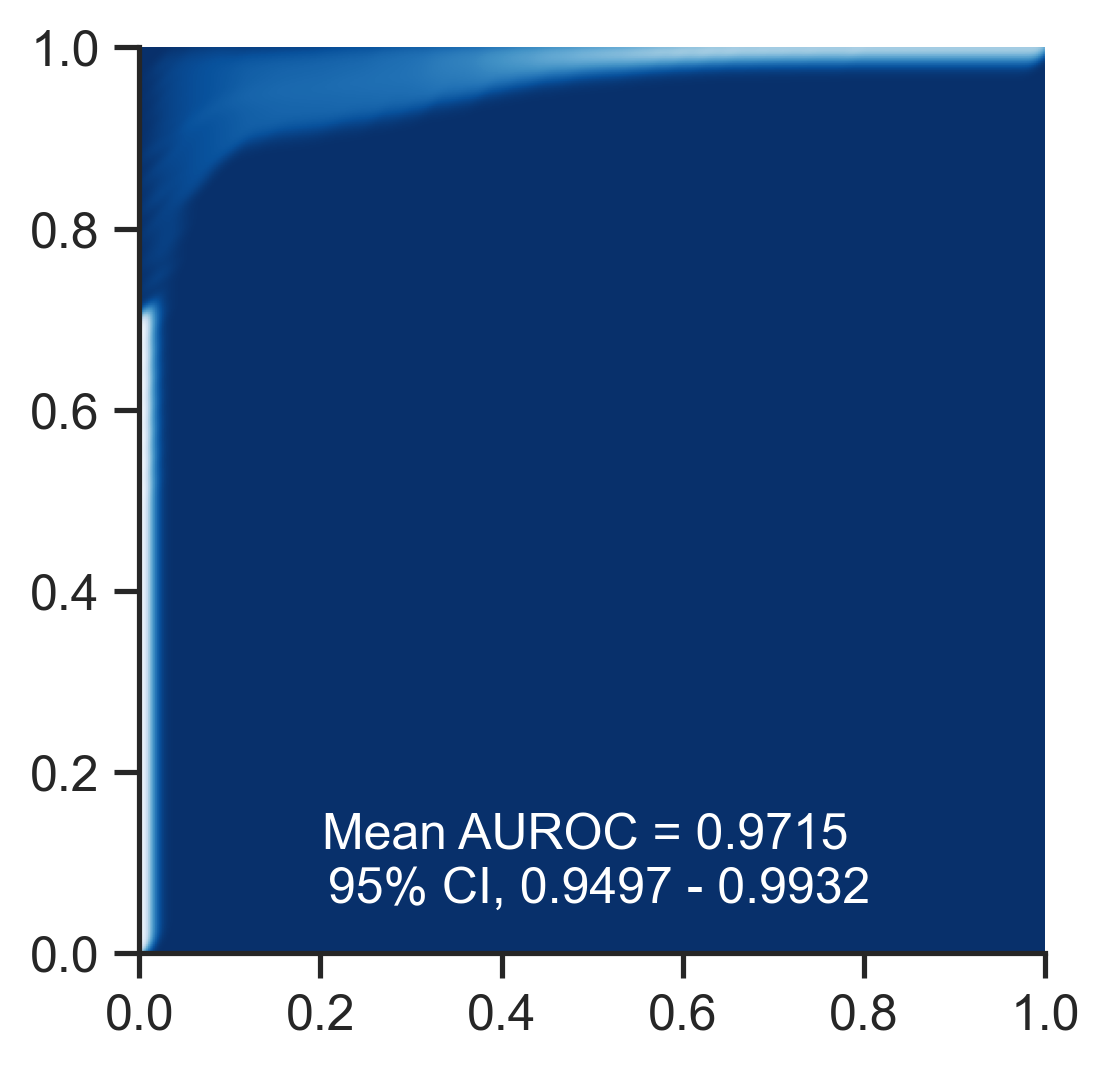

In [23]:
tprs_upper = []
tprs_lower = []
mean_fpr_ext = []
for ratio in np.arange(0.05,1,0.15):
    tprs_upper.append(mean_tpr_x + ratio*std_tpr_x)
    tprs_lower.append(mean_tpr_x - ratio*std_tpr_x)
    mean_fpr_ext.append(mean_fpr_x)
tprs_upper_ = np.array(tprs_upper).ravel()
tprs_lower_ = np.array(tprs_lower).ravel()
mean_fpr_ext_ = np.array(mean_fpr_ext).ravel()

# _tprs_ext = np.arange(0,0.85,0.0015)
# _mean_fpr_ext = np.zeros(len(_tprs_ext))

tprs_ul = np.concatenate((tprs_upper_, tprs_lower_), axis=None) #tprs_upper, tprs_lower
mean_fpr_all = np.concatenate((mean_fpr_ext_, mean_fpr_ext_), axis=None)

plot_roc_pr_train(mean_fpr_all, np.minimum(tprs_ul, 1), mean_auc, std_auc, 'Mean AUROC', 1)
plt.savefig("f_result/f3_train_whole_features_roc_img.pdf", bbox_inches='tight', pad_inches = 0.1)

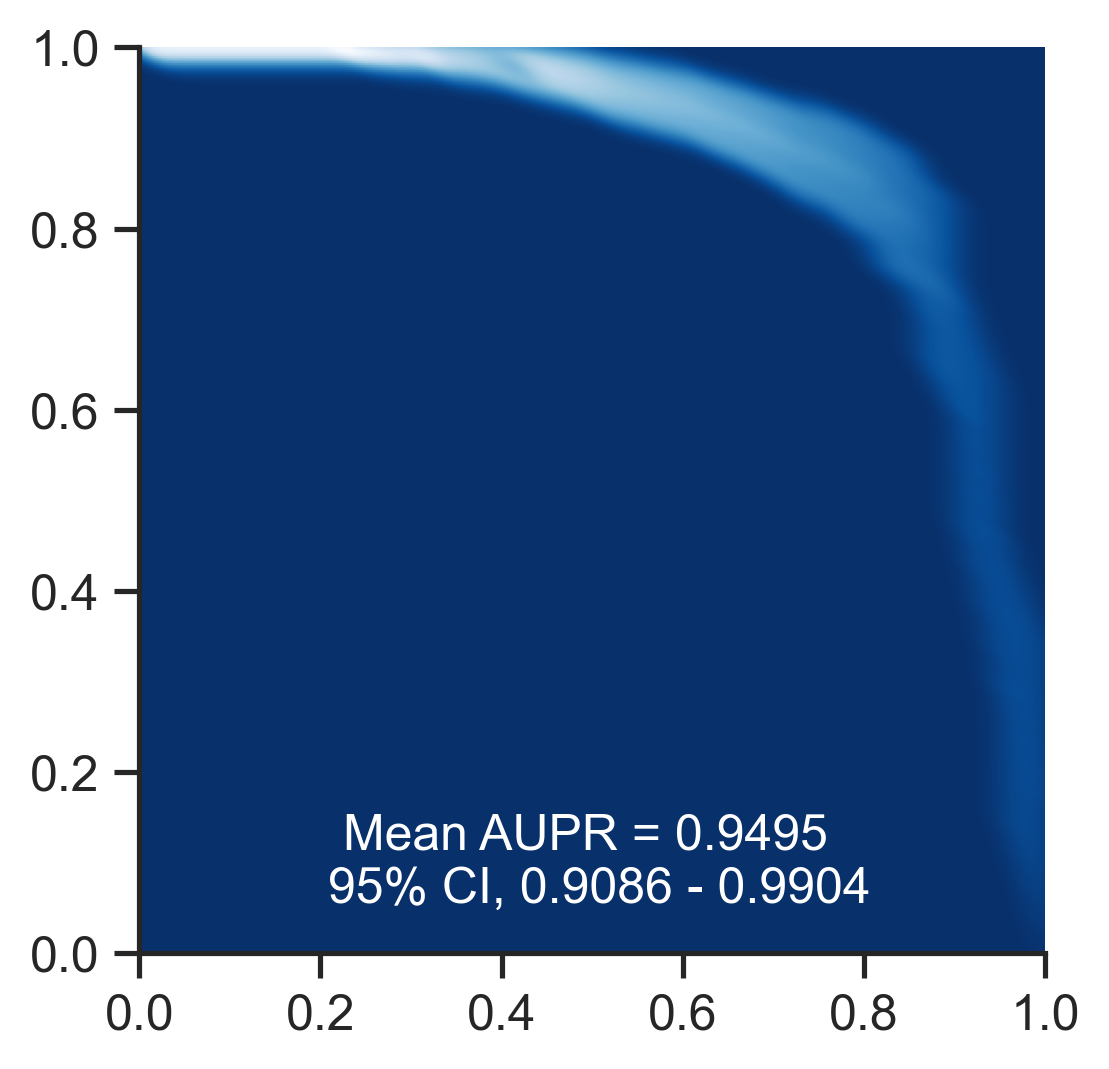

In [25]:
mean_precision_less = mean_precision[mean_precision<0.99]
mean_recalls_less = mean_recalls[mean_precision<0.99]
std_precision_less = std_precision[mean_precision<0.99]

precision_upper = []
precision_lower = []
mean_recall_ext = []
for ratio in np.arange(0,0.4,0.025):
    if ratio < 0.1:
        precision_upper.append(mean_precision_less + ratio*std_precision_less)
        precision_lower.append(mean_precision_less - ratio*std_precision_less)
        mean_recall_ext.append(mean_recalls_less)
    else:
        precision_upper.append(mean_precision + ratio*std_precision)
        precision_lower.append(mean_precision - ratio*std_precision)
        mean_recall_ext.append(mean_recalls)

precision_upper_=[]
for np_arr in precision_upper:
    for x in np_arr:
        precision_upper_.append(x)
precision_upper_ = np.array(precision_upper_)

precision_lower_=[]
for np_arr in precision_lower:
    for x in np_arr:
        precision_lower_.append(x)
precision_lower_ = np.array(precision_lower_)
        
mean_recall_ext_=[]
for np_arr in mean_recall_ext:
    for x in np_arr:
        mean_recall_ext_.append(x)
mean_recall_ext_ = np.array(mean_recall_ext_)       

precision_lower_ul = np.concatenate((precision_upper_, precision_lower_,), axis=None) #tprs_upper, tprs_lower
mean_recall_all = np.concatenate((mean_recall_ext_, mean_recall_ext_,), axis=None)

plot_roc_pr_train(mean_recall_all, np.minimum(precision_lower_ul, 1), mean_ap, std_ap, 'Mean AUPR',2)
# plot_roc_pr_train(mean_recalls, mean_precision, mean_ap, std_ap, 'Mean AUPR',4)
plt.savefig("f_result/f3_train_whole_features_pr_img.pdf",bbox_inches='tight', pad_inches = 0.1)

# trains with whole dataset

In [16]:

best_xgb = xgb.XGBClassifier(**best_params)
weight_class_dict = get_class_weight(y_train)
ins_weight_lst = [weight_class_dict[i] for i in y_train.values]
best_xgb.fit(X_train, y_train.values, sample_weight=ins_weight_lst)


/Users/yong/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1 2 3], y=0      0
1      0
2      0
3      0
4      0
      ..
103    0
104    3
105    2
106    2
107    1
Name: label, Length: 108, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=50, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=55, n_jobs=-1, num_boost_round=55, num_class=4,
              num_parallel_tree=1, objective='multi:softprob', random_state=123,
              reg_alpha=0.005, reg_lambda=1, scale_pos_weight=None, seed=123,
              subsample=0.7, tree_method=None, validate_parameters=False, ...)

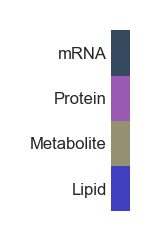

In [17]:

fig, ax = plt.subplots(figsize=(0.08, 0.8), dpi=300)
cmap = matplotlib.colors.ListedColormap(["#3f3fbf", "#95906f", "#9b59b6",  "#34495e"])
# ["#8e5847", "#3498db", "#9b59b6",  "#34495e"] new
# ["#95a5a6", "#3498db", "#9b59b6",  "#34495e"] old
bounds = [0,1, 2, 3, 4]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cbar = fig.colorbar(
    matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax,
    ticks=np.array(bounds)+0.5,
)
# {'lipid':'#8e5847','metabolic':'#3498db','protein':'#9b59b6','mrna':'#34495e'})
cbar.ax.set_yticklabels(['Lipid', 'Metabolite', 'Protein', 'mRNA'])
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0, labelsize=4, pad=1)
ax.yaxis.set_ticks_position('left')

plt.savefig("f_result/f3_omics_legend_left.pdf", dpi=400)
# ax.yaxis.set_label_position('left')

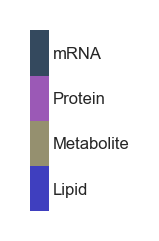

In [18]:
fig, ax = plt.subplots(figsize=(0.08, 0.8), dpi=300)
cmap = matplotlib.colors.ListedColormap(["#3f3fbf", "#95906f", "#9b59b6",  "#34495e"])
# ["#8e5847", "#3498db", "#9b59b6",  "#34495e"]
# ["#95a5a6", "#3498db", "#9b59b6",  "#34495e"] old
bounds = [0,1, 2, 3, 4]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cbar = fig.colorbar(
    matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=ax,
    ticks=np.array(bounds)+0.5,
)
# {'lipid':'#8e5847','metabolic':'#3498db','protein':'#9b59b6','mrna':'#34495e'})
cbar.ax.set_yticklabels(['Lipid', 'Metabolite', 'Protein', 'mRNA'])
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0, labelsize=4, pad=1)
plt.savefig("f_result/f3_omics_legend_right.pdf", dpi=400)
# ax.yaxis.set_ticks_position('left')
# ax.yaxis.set_label_position('left')

In [20]:
d_feat_columns = X_train.columns.to_list()
d_feat_cat = [x.split('_', 1)[0] for x in d_feat_columns]
d_feat_name = [x.split('_', 1)[1] for x in d_feat_columns]
d_feat_cat_series = pd.Series(d_feat_cat)
d_feat_cat_series_capital = d_feat_cat_series.map(
    {'lipid':'Lipid','metabolic':'Metabolite','protein':'Protein','mrna':'mRNA'})
d_feat_cat_color = d_feat_cat_series.map(
    {'lipid':'#3f3fbf','metabolic':'#95906f','protein':'#9b59b6','mrna':'#34495e'})
# ["#3f3fbf", "#95906f", "#9b59b6",  "#34495e"]

d_feat_cat_pd1 = pd.DataFrame(data={'ori_name':d_feat_columns,
                                   'feat_name':d_feat_name,
                                  'cat_name':d_feat_cat,
                                  'cat_name_captical':d_feat_cat_series_capital.values,
                                  'cat_color':d_feat_cat_color.values})

In [21]:
# d_feat_cat_pd.to_csv('All_features_4.csv', sep='\t', index=False)
# merge feature name
# All_features_4_1_by.csv 3 columns: ori_name true_name synonym
features_frames = [d_feat_cat_pd1, pd.read_csv('final_feature_list.txt',sep='\t')]

d_feat_cat_pd = reduce(lambda  left,right: pd.merge(left,right,on=['ori_name'],
                                            how='left'), features_frames)
print(d_feat_cat_pd.shape)
d_feat_cat_pd.head()

(298, 7)


,ori_name,feat_name,cat_name,cat_name_captical,cat_color,true_name,synonym
0,lipid_0.91_457.236133082317,0.91_457.236133082317,lipid,Lipid,#3f3fbf,LPA(20:4),LPA(20:4)
1,lipid_1.06_526.315297143293,1.06_526.315297143293,lipid,Lipid,#3f3fbf,LPC(15:0),LPC(15:0)
2,lipid_1.42_510.35586089939,1.42_510.35586089939,lipid,Lipid,#3f3fbf,LPC(17:0)(rep),LPC(17:0)
3,lipid_1.88_538.387065481707,1.88_538.387065481707,lipid,Lipid,#3f3fbf,LPC(19:0)(rep),LPC(19:0)
4,lipid_11.44_908.864068881098,11.44_908.864068881098,lipid,Lipid,#3f3fbf,LPC(19:0),TG(18:0/18:0/18:0)


In [22]:
## save all feature
# d_feat_cat_pd_1 = reduce(lambda  left,right: pd.merge(left,right,on=['ori_name'],
#                                             how='outer'), features_frames)

# d_feat_cat_pd_1.to_csv('new_sel_feature.txt', sep=',',index=False, encoding='utf-8-sig')

In [23]:
import shap
import re
from matplotlib import colors
class_names = ['Asymptomatic','Mild', 'Severe', 'Critical']
top_feat = 60
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_train) # same to x

vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(d_feat_cat_pd['ori_name'], sum(vals))), columns=['ori_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.reset_index(drop=True,inplace=True)
full_features_df = feature_importance.merge(d_feat_cat_pd,on='ori_name',how='left')
full_top60_features_df=full_features_df[:top_feat].copy()
full_top60_features_df.to_csv('top60_features_4.csv', index=False)

full_top60_features_df.head()


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


,ori_name,feature_importance_vals,feat_name,cat_name,cat_name_captical,cat_color,true_name,synonym
0,mrna_ALOX15,18.184391,ALOX15,mrna,mRNA,#34495e,ALOX15,ALOX15
1,metabolic_0.658_133.0375,12.892462,0.658_133.0375,metabolic,Metabolite,#95906f,L-aspartate,L-Aspartate
2,mrna_CDC42EP2,12.197368,CDC42EP2,mrna,mRNA,#34495e,CDC42EP2,CDC42EP2
3,protein_TXLNB,10.715579,TXLNB,protein,Protein,#9b59b6,TXLNB,TXLNB
4,lipid_4.97_850.561087451219,8.997099,4.97_850.561087451219,lipid,Lipid,#3f3fbf,PC(18:2/20:4),PC(18:2/20:4)


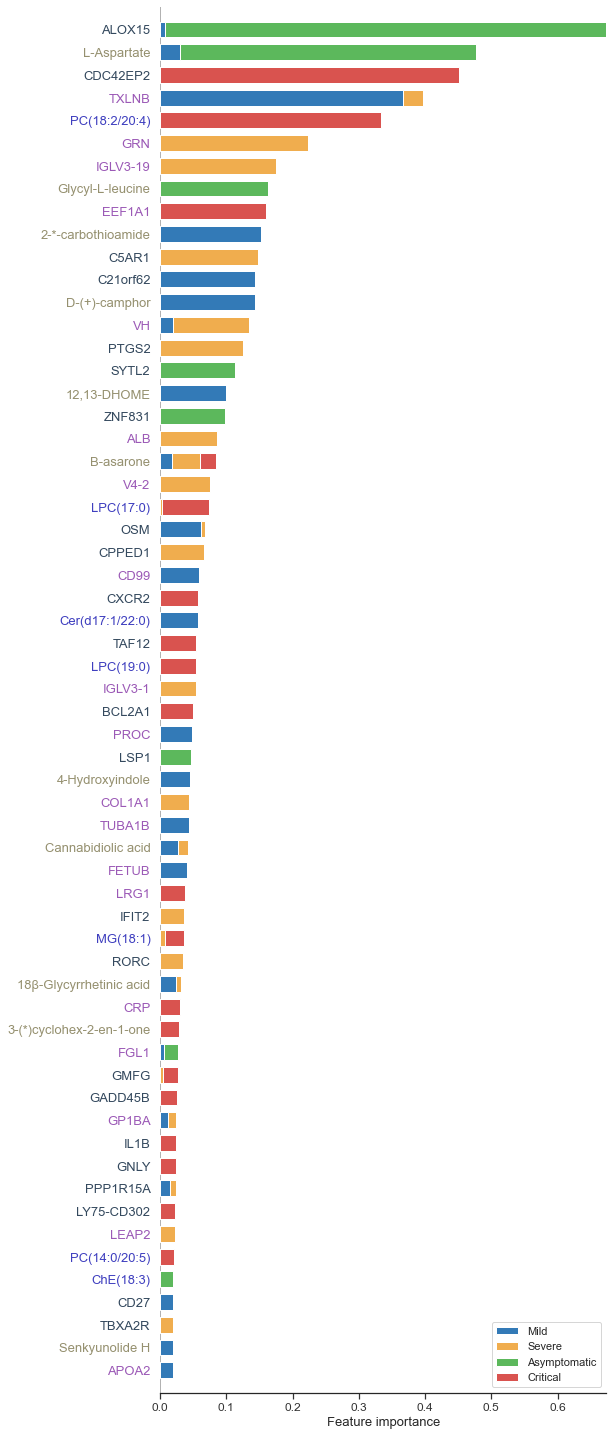

In [24]:
# classes colors
colorss = ["#5cb85c", "#337ab7", "#f0ad4e", "#d9534f"]
# get class ordering from shap values
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
# create listed colormap
cmap = colors.ListedColormap(np.array(colorss)[class_inds])
shap.summary_plot(shap_values, X_train.values, 
                  show=False, feature_names=d_feat_cat_pd['synonym'].values, max_display=top_feat, 
                  class_names=class_names,color=cmap)
plt.xlabel("Feature importance")
# y ticklables color
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
for iidx, lbl in enumerate(xlbls):
    lbl.set_color(full_top60_features_df.loc[top_feat-1-iidx, 'cat_color'])
plt.xticks(fontsize=12)
plt.legend(loc="best")
plt.savefig("f_result/f3_feature_importance.pdf", bbox_inches='tight', pad_inches = 0.1)

In [25]:
full_top60_features_df['cat_name'].value_counts()

mrna         23
protein      19
metabolic    11
lipid         7
Name: cat_name, dtype: int64

In [26]:
top_feat_names = feature_importance['ori_name'].values[:top_feat]

In [27]:
norm_test_lipid_df=pd.read_csv('f_data/norm_test_lipid_df_27.csv', sep='\t')
norm_test_metabolic_df=pd.read_csv('f_data/norm_test_metabolic_df_27.csv', sep='\t')
norm_test_protein_df=pd.read_csv('f_data/norm_test_protein_df_27.csv', sep='\t')
norm_test_mrna_df=pd.read_csv('f_data/norm_test_mrna_df_27.csv', sep='\t')

test_frames = [norm_test_lipid_df, norm_test_metabolic_df, norm_test_protein_df, norm_test_mrna_df]

comb_test_df = reduce(lambda  left,right: pd.merge(left,right,
                                                   on=['PatientID','label_trans'],
                                                   how='inner'), test_frames)

y_test = comb_test_df['label_trans']
X_test_top = comb_test_df[top_feat_names]

In [28]:
X_train_top = X_train[top_feat_names]

In [29]:
top_x_df = pd.concat([X_train_top,X_test_top]).reset_index(drop=True)
y=pd.concat([y_train,y_test]).reset_index(drop=True)

In [30]:
top_x_df.to_csv('top60_omics_data_x.csv',sep='\t', index=False, header = full_top60_features_df['synonym'].values)
y.to_csv('top60_omics_data_y.csv',sep='\t', index=False, header=['label'])

In [31]:
top_x_df.shape

(135, 60)

In [32]:
y

0      0
1      0
2      0
3      0
4      0
      ..
130    2
131    3
132    1
133    1
134    2
Length: 135, dtype: int64

# Train with different number of features

In [27]:
# np.savez('t_sne_embedding.npz', x=X_embedded, y=y_symb )

In [26]:
# I agree, apparently markers only accepts these markers in scatterplot:
# filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
# https://matplotlib.org/2.0.2/api/markers_api.html
def plot_umap(x_df, y_series,out_file=None):
    
    import umap
    markers = ('d','o','^','X')
#     palette = dict({'Asymptomatic':"#66A61E", 'Mild':"#FFE699", 'Severe':"#619CFF", 'Critical':"darkred"})
    # palette = ["#66A61E", "#FFE699", "#619CFF", "darkred"]
    palette = dict({'Asymptomatic':"#5cb85c", 'Mild':"#337ab7", 'Severe':"#f0ad4e", 'Critical':"#d9534f"})
    
    # ["#5cb85c", "#337ab7", "#f0ad4e", "darkred"]

    umap_ = umap.UMAP(n_neighbors=10,min_dist=0.5, random_state=123, metric='manhattan')  
    
    # min_dist=0.25,123,1233, correlation, euclidean
    umap_embedding = umap_.fit_transform(x_df)
    y_symb = y_series.map({0:'Asymptomatic',1:'Mild', 2:'Severe', 3:'Critical'})
    sns.scatterplot(umap_embedding[:,0], umap_embedding[:,1], 
                    markers=markers,hue=y_symb.values,style=y_symb.values,
                    palette=palette,legend='full',s=100) # style=y_symb.values
    plt.xlabel('UMAP_1')
    plt.ylabel('UMAP_2')
#     plt.gca().set_aspect('equal', adjustable='box') 
    plt.legend(loc="best")
    sns.despine()
    

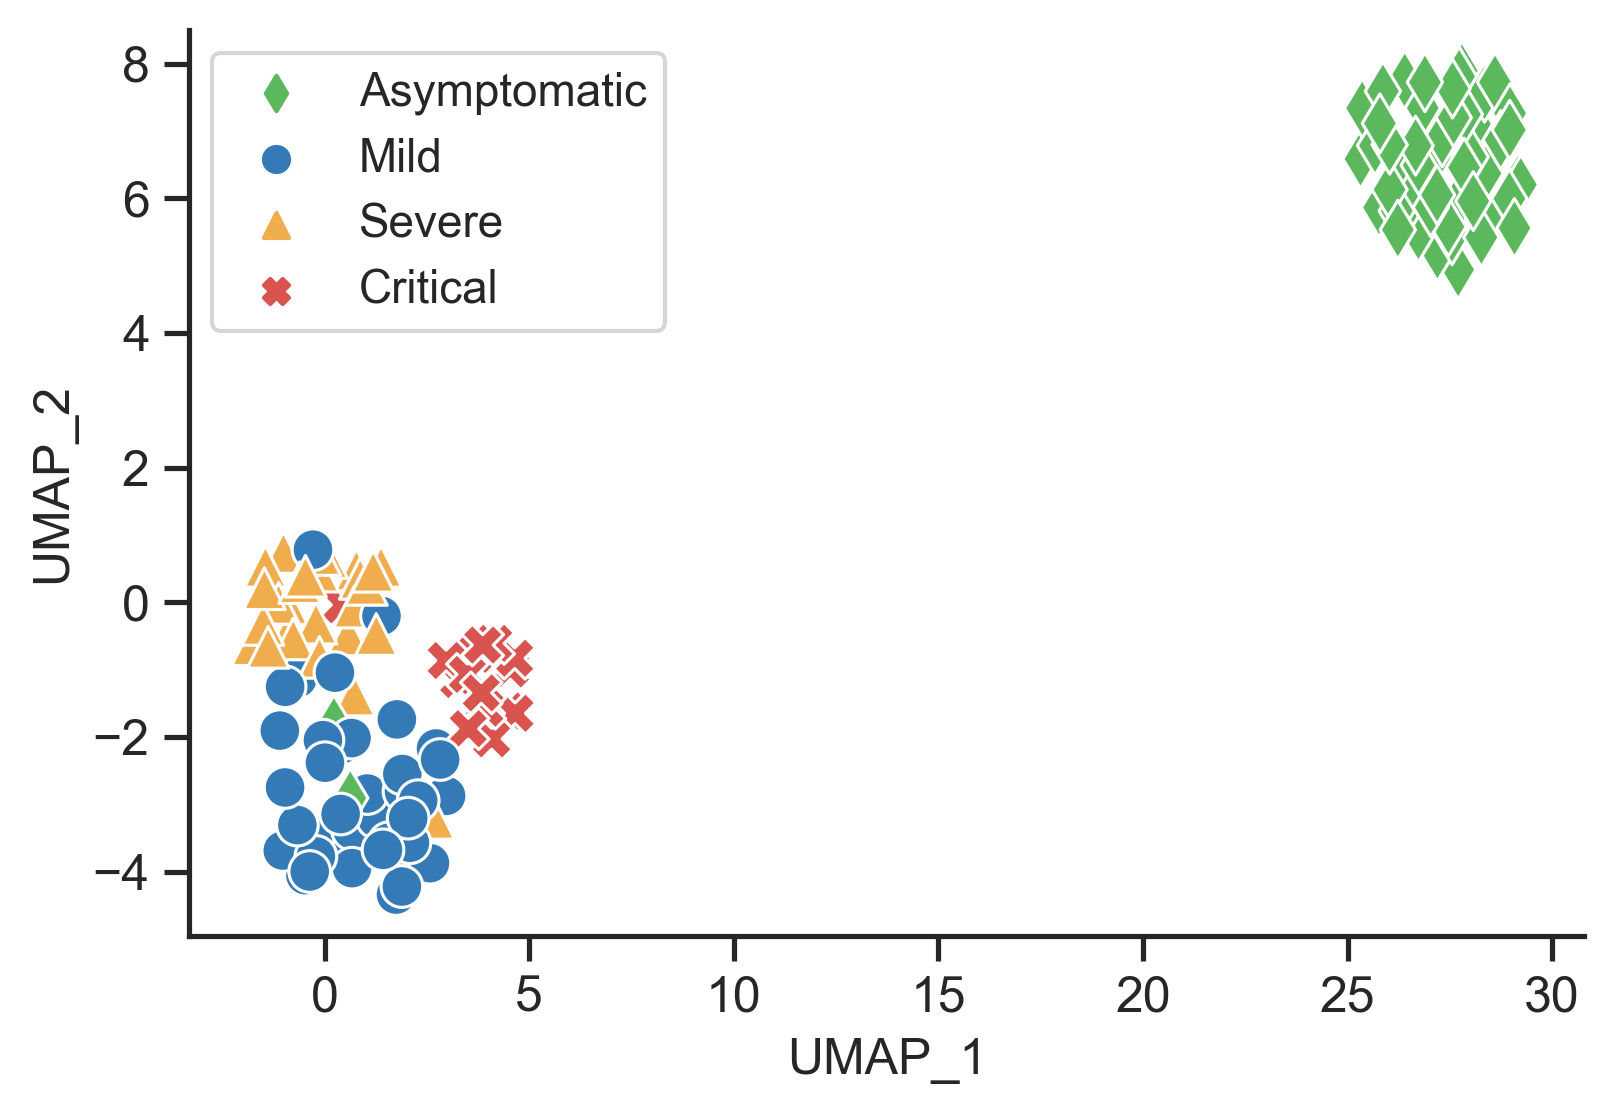

In [27]:
plot_umap(top_x_df,y)

plt.savefig("f_result/f3_umap.pdf", bbox_inches='tight', pad_inches = 0.1)

In [28]:
# np.savez('umap_embedding.npz', x=umap_embedding, y=y_symb )

In [29]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

top_feature_samples=top_x_df.copy()
top_feature_samples['Label']=y
top_feature_samples.sort_values(by='Label',inplace=True)
top_feature_samples.reset_index(drop=True, inplace=True)
y_top_sample = top_feature_samples['Label']
x_top_sample = top_feature_samples.drop(columns=['Label'])

# x_top_sample.rename(columns = dict(zip(x_top_sample.columns.to_list(), 
#                                        [x.split('_',1)[1] for x in x_top_sample.columns.to_list()])), inplace=True)


# x_top_sample_corr = x_top_sample.T.corr()
# x_top_sample_dism = 1 - x_top_sample_corr   # distance matrix
# linkage = hc.linkage(sp.distance.squareform(x_top_sample_dism), method='average')

# # https://python-graph-gallery.com/402-color-dendrogram-labels/
# linkage2 = hc.linkage(x_top_sample, 'ward')


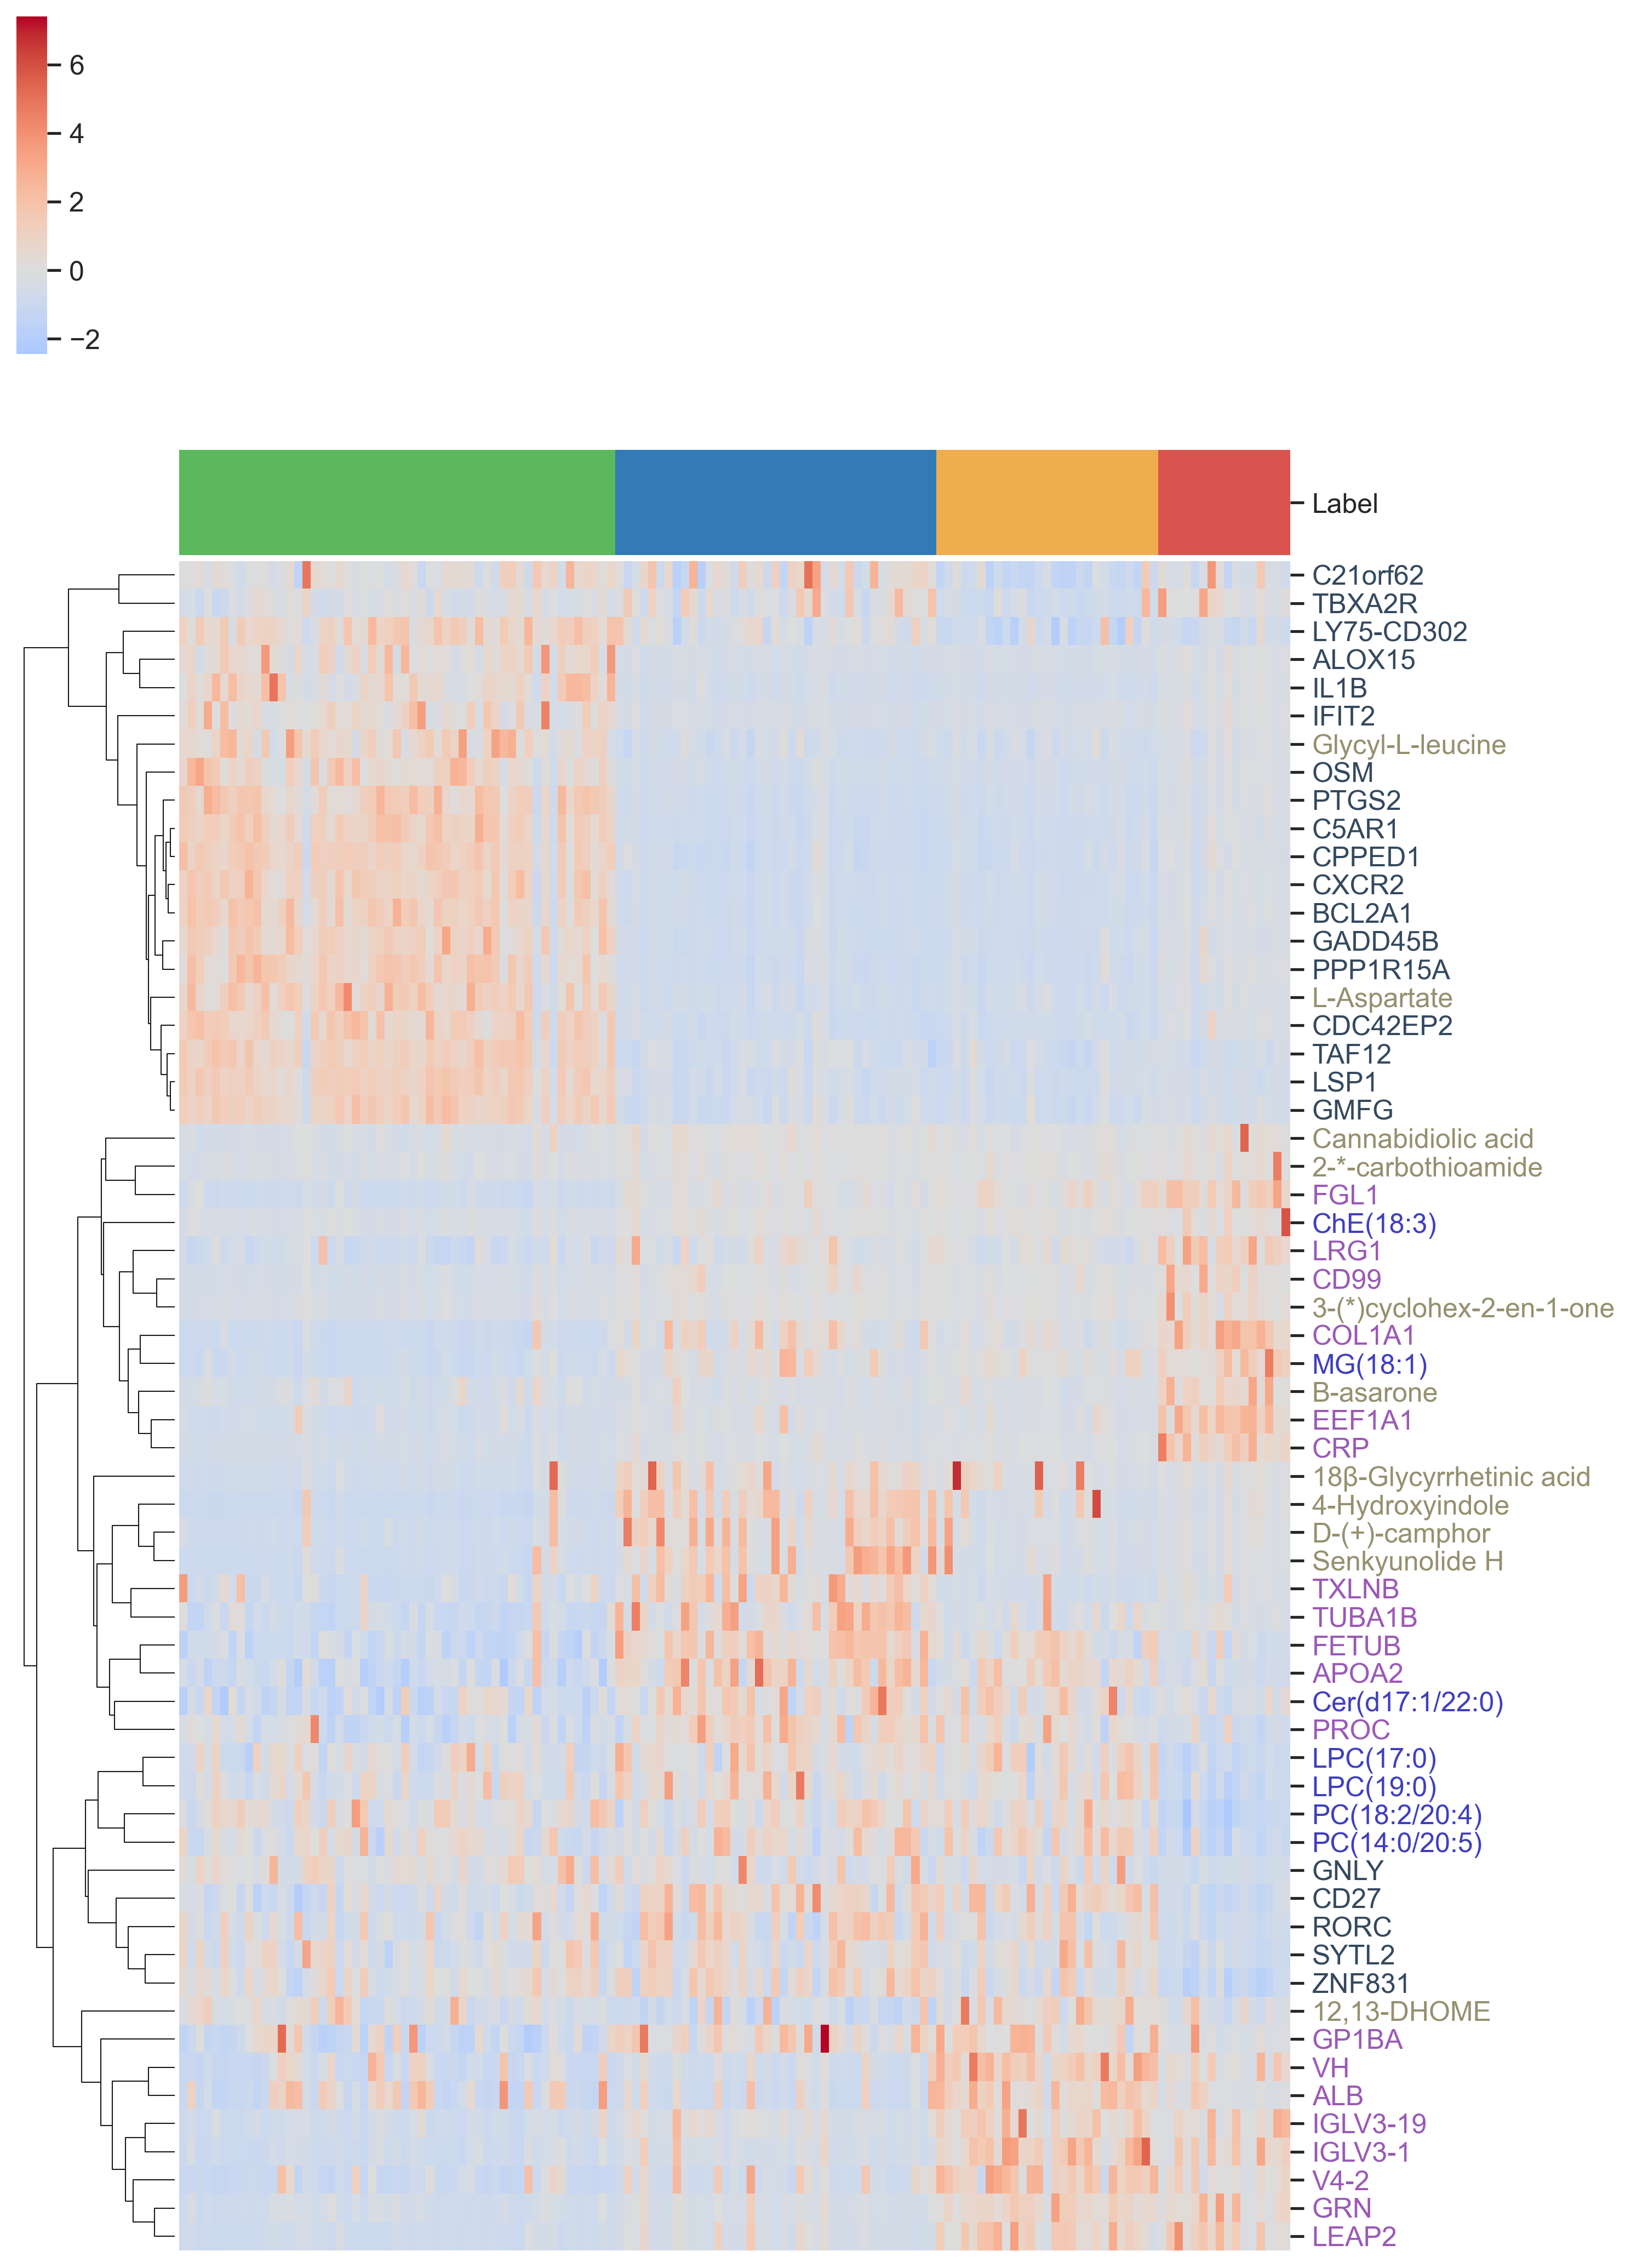

In [30]:
# fig, ax = plt.subplots(figsize=(11.7/1.2,12))
y_symb = y_top_sample.map({0:'Asymptomatic',1:'Mild', 2:'Severe', 3:'Critical'})
lut = dict(zip(y_symb.unique(), ["#5cb85c", "#337ab7", "#f0ad4e", "#d9534f"]))
col_colors = y_symb.map(lut)

g = sns.clustermap(x_top_sample.T, col_colors=col_colors, cmap=plt.get_cmap("coolwarm"),figsize=(10, 18), center=0.0,
                   row_cluster=True, col_cluster=False, metric="correlation", method='complete',z_score=1,
                   xticklabels=False,) 
# cg.dendrogram_col.linkage # linkage matrix for columns
# cg.dendrogram_row.linkage # linkage matrix for rows
# standard_scale
#metric="correlation", col_linkage=linkage, col_colors=col_colors,cmap=sns.color_palette("coolwarm"),z_score=1,robust=True,method='complete'
xlbls = g.ax_heatmap.yaxis.get_majorticklabels()
y_ticklabesl_colors = []
for lbl in xlbls:
    y_ticklabesl_colors.append(full_top60_features_df.loc[
        full_top60_features_df['ori_name']==lbl.get_text(),['synonym','cat_color']].values[0])  
y_ticklabesl_colors_arr = np.array(y_ticklabesl_colors)
g.ax_heatmap.set_yticklabels(y_ticklabesl_colors_arr[:,0])

xlbls = g.ax_heatmap.yaxis.get_majorticklabels()
for iidex,lbl in enumerate(xlbls):

    lbl.set_color(y_ticklabesl_colors_arr[iidex,1])

plt.savefig("f_result/f3_heatmap.pdf", bbox_inches='tight', pad_inches = 0.1)

In [45]:
mean_tpr,std_tpr,mean_fpr,mean_auc,std_auc, mean_precision, std_precision, mean_recalls, mean_ap, std_ap= roc_pr_cv(
    best_params, X_train_top, y_train, iteration=100, random_state=None)

# re_train with top 60 features

In [31]:
# from yellowbrick.classifier import ROCAUC

# best_xgb = xgb.XGBClassifier(**best_params)
# weight_class_dict = get_class_weight(y_train)
# ins_weight_lst = [weight_class_dict[i] for i in y_train.values]
# best_xgb.fit(X_train_top, y_train.values, sample_weight=ins_weight_lst)
# class_lab = [0,1, 2, 3]
# rocauc = ROCAUC(best_xgb, classes=class_lab)
# rocauc.score(X_test_top, y_test.values)
# rocauc.show()

In [33]:
X_train_top.shape,X_test_top.shape

((108, 60), (27, 60))

In [34]:
pd.Series(y_train).value_counts()

0    42
1    31
2    22
3    13
Name: label, dtype: int64

In [35]:
pd.Series(y_test).value_counts()

0    11
1     8
2     5
3     3
Name: label_trans, dtype: int64

## Train uncalibration

In [36]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

# retrain the model with top k features
best_xgb = xgb.XGBClassifier(**best_params)
weight_class_dict = get_class_weight(y_train)
ins_weight_lst = [weight_class_dict[i] for i in y_train.values]
best_xgb.fit(X_train_top, y_train.values, sample_weight=ins_weight_lst)

Pass classes=[0 1 2 3], y=0      0
1      0
2      0
3      0
4      0
      ..
103    0
104    3
105    2
106    2
107    1
Name: label, Length: 108, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=50, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=55, n_jobs=-1, num_boost_round=55, num_class=4,
              num_parallel_tree=1, objective='multi:softprob', random_state=123,
              reg_alpha=0.005, reg_lambda=1, scale_pos_weight=None, seed=123,
              subsample=0.7, tree_method=None, validate_parameters=False, ...)

In [37]:
p_pred_prob=best_xgb.predict_proba(X_test_top)
p_pred_prob

array([[0.8977215 , 0.0299302 , 0.0444222 , 0.02792604],
       [0.04413258, 0.07143594, 0.07321432, 0.8112171 ],
       [0.08507127, 0.81699955, 0.05106598, 0.04686323],
       [0.03395338, 0.1065618 , 0.06807107, 0.7914137 ],
       [0.03952698, 0.34672448, 0.55342263, 0.06032589],
       [0.05929977, 0.73100907, 0.07099901, 0.13869217],
       [0.04657613, 0.05706003, 0.8068398 , 0.08952398],
       [0.08256258, 0.7135948 , 0.0735053 , 0.13033733],
       [0.8376462 , 0.02775505, 0.10521282, 0.02938587],
       [0.8553081 , 0.04808602, 0.06735951, 0.02924637],
       [0.08242199, 0.2616841 , 0.5775092 , 0.0783847 ],
       [0.07570518, 0.06204797, 0.824186  , 0.03806083],
       [0.8918736 , 0.03404573, 0.04412914, 0.02995157],
       [0.9008402 , 0.02904249, 0.04209417, 0.02802306],
       [0.89183444, 0.04808588, 0.03233675, 0.02774291],
       [0.0572084 , 0.1036226 , 0.7762503 , 0.06291865],
       [0.8538953 , 0.03164686, 0.06951862, 0.04493921],
       [0.85169446, 0.0323124 ,

In [38]:
classes=[0, 1, 2, 3]
y_val = label_binarize(y_test, classes=classes)
n_classes = len(classes)
y_val

array([[1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0]])

In [39]:

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

precision = dict()
recall = dict()
apr=dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], p_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    precision[i], recall[i], _ = precision_recall_curve(y_val[:, i],
                                                        p_pred_prob[:, i])
    apr[i] = average_precision_score(y_val[:, i], p_pred_prob[:, i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), p_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# # First aggregate all false positive rates
# all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# # Then interpolate all ROC curves at this points
# mean_tpr = np.zeros_like(all_fpr)
# for i in range(n_classes):
#     mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# # Finally average it and compute AUC
# mean_tpr /= n_classes

# fpr["macro"] = all_fpr
# tpr["macro"] = mean_tpr
# roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# pr
precision['micro'], recall['micro'], _ = precision_recall_curve(y_val.ravel(), p_pred_prob.ravel())
apr['micro'] = average_precision_score(y_val, p_pred_prob, average="micro")


In [40]:
# save the test preformace
np.savez('f_data/multi-omics_test_performance.npz', 
         fpr_micro=fpr["micro"], tpr_micro=tpr["micro"], auroc=roc_auc["micro"],
         prec_micro = precision['micro'], recall_micro=recall['micro'], auprc=apr['micro'])

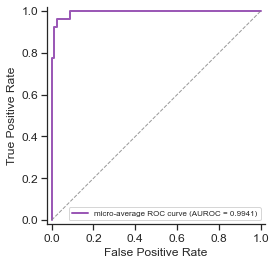

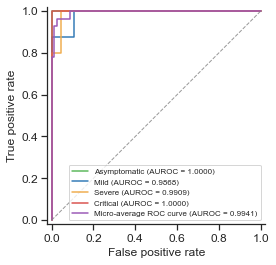

In [41]:
# plt.figure(figsize=(10, 8), dpi=300)

plt.plot(fpr["micro"], tpr["micro"], 
         label='micro-average ROC curve (AUROC = %0.4f)' % roc_auc["micro"], 
         color='#9b59b6',lw=2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray',alpha=.8)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Micro-average Receiver operating characteristic')
plt.legend(loc="lower right",prop={'size': 8})
plt.gca().set_aspect('equal', adjustable='box') 
sns.despine()
plt.show()

# Plot ROC curve
class_lab = {0:'Asymptomatic',1:'Mild', 2:'Severe', 3:'Critical'}
colorss = ["#5cb85c", "#337ab7", "#f0ad4e", "#d9534f"]
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colorss[i],
             label='{0} (AUROC = {1:0.4f})'
                                   ''.format(class_lab[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], color='#9b59b6',
         label='Micro-average ROC curve (AUROC = {0:0.4f})'
               ''.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray',alpha=.8)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
# plt.title('Receiver operating characteristic for all stage')
plt.legend(loc="lower right",prop={'size': 8})
plt.gca().set_aspect('equal', adjustable='box') 
sns.despine()
plt.savefig("f_result/f3_test_roc.pdf", bbox_inches='tight', pad_inches = 0.1)
plt.show()

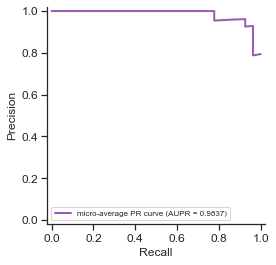

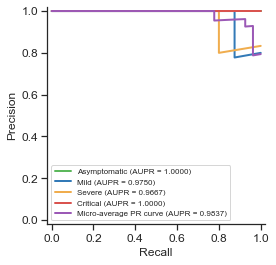

In [42]:
# plt.figure(figsize=(10, 8), dpi=300)
# plt.plot(np.concatenate(([1],recall["micro"])), np.concatenate(([0],precision["micro"])), 
#          label='micro-average PR curve (AUPR = %0.3f)' % apr["micro"], 
#          color='#34495e',lw=2)
plt.plot(recall["micro"], precision["micro"], 
         label='micro-average PR curve (AUPR = %0.4f)' % apr["micro"], 
         color='#9b59b6',lw=2)
# plt.plot([0, 1], [1, 0], 'r--', lw=2, alpha=.8)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.title('Micro-average PR Curve')
plt.legend(loc="lower left",prop={'size': 8})
plt.gca().set_aspect('equal', adjustable='box') 
sns.despine()
plt.show()

# Plot ROC curve
plt.figure()
class_lab = {0:'Asymptomatic',1:'Mild', 2:'Severe', 3:'Critical'}
colorss = ["#5cb85c", "#337ab7", "#f0ad4e", "#d9534f"]
for i in range(n_classes):
    plt.plot(recall[i], precision[i], color=colorss[i],lw=2,
             label='{0} (AUPR = {1:0.4f})'
             ''.format(class_lab[i], apr[i]))
    
plt.plot(recall["micro"],precision["micro"],color='#9b59b6',lw=2,
         label='Micro-average PR curve (AUPR = {0:0.4f})'
               ''.format(apr["micro"]))



# plt.plot([0, 1], [1, 0], 'r--', lw=2, alpha=.8)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.title('PR Curve for classes')
plt.legend(loc="lower left",prop={'size': 8})
plt.gca().set_aspect('equal', adjustable='box') 
sns.despine()
plt.savefig("f_result/f3_test_pr.pdf", bbox_inches='tight', pad_inches = 0.1)
plt.show()

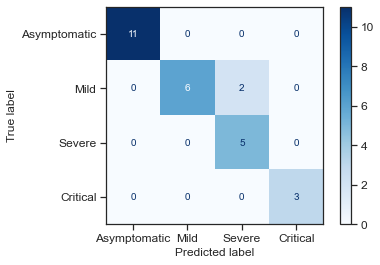

In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

class_names = ['Asymptomatic', 'Mild', 'Severe', 'Critical']

x_in = X_test_top
plot_confusion_matrix(best_xgb,X_test_top, y_test.values,
                      display_labels=class_names, cmap=plt.cm.Blues, normalize=None)
plt.savefig("f_result/f3_cm.pdf", bbox_inches='tight', pad_inches = 0.1)

In [44]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[11  0  0  0]
 [ 0  6  2  0]
 [ 0  0  5  0]
 [ 0  0  0  3]]


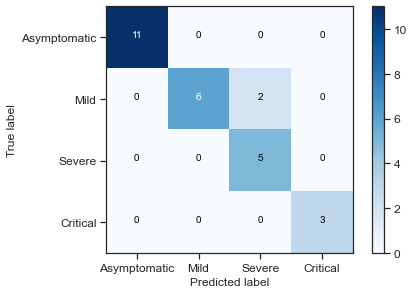

In [45]:
from sklearn.metrics import confusion_matrix
pp_predd =best_xgb.predict_proba(X_test_top)
# cm2 = ConfusionMatrix(actual_vector=y_test.values, predict_vector=np.argmax(pp_predd, axis=1))
cnf_matrix = confusion_matrix(y_test.values, np.argmax(pp_predd, axis=1))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=None, title = None)
# plt.savefig("f_result/f3_cm.pdf", bbox_inches='tight', pad_inches = 0.1)

In [46]:
from sklearn.metrics import classification_report
p_pred_l = np.argmax(p_pred_prob,axis=1)
print(classification_report(y_test.values, p_pred_l, target_names=class_names))

              precision    recall  f1-score   support

Asymptomatic       1.00      1.00      1.00        11
        Mild       1.00      0.75      0.86         8
      Severe       0.71      1.00      0.83         5
    Critical       1.00      1.00      1.00         3

    accuracy                           0.93        27
   macro avg       0.93      0.94      0.92        27
weighted avg       0.95      0.93      0.93        27



In [47]:
from pycm import *
cm = ConfusionMatrix(actual_vector=y_test.values, predict_vector=p_pred_l)


In [48]:
cm.overall_stat

{'Overall ACC': 0.9259259259259259,
 'Kappa': 0.8953488372093024,
 'Overall RACC': 0.29218106995884774,
 'SOA1(Landis & Koch)': 'Almost Perfect',
 'SOA2(Fleiss)': 'Excellent',
 'SOA3(Altman)': 'Very Good',
 'SOA4(Cicchetti)': 'Excellent',
 'SOA5(Cramer)': 'Very Strong',
 'SOA6(Matthews)': 'Very Strong',
 'TNR Macro': 0.9772727272727273,
 'TPR Macro': 0.9375,
 'FPR Macro': 0.022727272727272707,
 'FNR Macro': 0.0625,
 'PPV Macro': 0.9285714285714286,
 'ACC Macro': 0.962962962962963,
 'F1 Macro': 0.9226190476190477,
 'TNR Micro': 0.9753086419753086,
 'FPR Micro': 0.024691358024691357,
 'TPR Micro': 0.9259259259259259,
 'FNR Micro': 0.07407407407407407,
 'PPV Micro': 0.9259259259259259,
 'F1 Micro': 0.9259259259259259,
 'Scott PI': 0.8949416342412453,
 'Gwet AC1': 0.9031679617453676,
 'Bennett S': 0.9012345679012346,
 'Kappa Standard Error': 0.0712060971739296,
 'Kappa 95% CI': (0.7557848867484003, 1.0349127876702044),
 'Chi-Squared': 68.46428571428571,
 'Phi-Squared': 2.5357142857142856,


In [49]:
cm.class_stat

{'TPR': {0: 1.0, 1: 0.75, 2: 1.0, 3: 1.0},
 'TNR': {0: 1.0, 1: 1.0, 2: 0.9090909090909091, 3: 1.0},
 'PPV': {0: 1.0, 1: 1.0, 2: 0.7142857142857143, 3: 1.0},
 'NPV': {0: 1.0, 1: 0.9047619047619048, 2: 1.0, 3: 1.0},
 'FNR': {0: 0.0, 1: 0.25, 2: 0.0, 3: 0.0},
 'FPR': {0: 0.0, 1: 0.0, 2: 0.09090909090909094, 3: 0.0},
 'FDR': {0: 0.0, 1: 0.0, 2: 0.2857142857142857, 3: 0.0},
 'FOR': {0: 0.0, 1: 0.09523809523809523, 2: 0.0, 3: 0.0},
 'ACC': {0: 1.0, 1: 0.9259259259259259, 2: 0.9259259259259259, 3: 1.0},
 'F1': {0: 1.0, 1: 0.8571428571428571, 2: 0.8333333333333334, 3: 1.0},
 'MCC': {0: 1.0, 1: 0.823754471047914, 2: 0.8058229640253802, 3: 1.0},
 'BM': {0: 1.0, 1: 0.75, 2: 0.9090909090909092, 3: 1.0},
 'MK': {0: 1.0, 1: 0.9047619047619047, 2: 0.7142857142857144, 3: 1.0},
 'PLR': {0: 'None', 1: 'None', 2: 10.999999999999996, 3: 'None'},
 'NLR': {0: 0.0, 1: 0.25, 2: 0.0, 3: 0.0},
 'DOR': {0: 'None', 1: 'None', 2: 'None', 3: 'None'},
 'TP': {0: 11, 1: 6, 2: 5, 3: 3},
 'TN': {0: 16, 1: 19, 2: 20, 3:

# train calibration

In [50]:
X_train_top

,mrna_ALOX15,metabolic_0.658_133.0375,mrna_CDC42EP2,protein_TXLNB,lipid_4.97_850.561087451219,protein_GRN,protein_IGLV3-19,metabolic_3.061_188.1164,protein_EEF1A1,metabolic_3.57_253.125,...,mrna_GNLY,mrna_PPP1R15A,mrna_LY75-CD302,protein_LEAP2,lipid_3.87_796.51342727439,lipid_9.36_647.576264381098,mrna_CD27,mrna_TBXA2R,metabolic_8.194_224.1052,protein_APOA2
0,0.807616,0.943943,1.348626,3.987720,0.155210,-0.525489,-0.598878,0.942738,-0.045642,-0.079019,...,0.537796,0.519439,1.341149,-0.536608,1.189788,-0.159926,-0.001063,-0.210628,-0.519508,-0.087474
1,3.829374,1.032317,1.812553,-0.635043,1.147930,-0.520733,-0.507647,-0.091676,-0.381046,-0.092608,...,0.508133,0.350608,2.140339,-0.529226,-0.040995,-0.172071,-0.364806,-0.246992,-0.517612,0.168165
2,1.134929,0.327377,0.861757,0.800065,1.853152,-0.511661,-0.232754,0.817046,-0.383432,-0.102876,...,1.812201,0.097487,0.915892,-0.516776,-0.737092,-0.169677,0.019258,-0.091149,-0.521878,-0.008517
3,0.331047,1.595755,0.854110,0.072775,0.602660,-0.523702,-0.451992,0.385086,-0.386030,-0.048878,...,2.529122,0.327573,1.102858,-0.520902,-0.686885,-0.164138,-0.886036,-0.226213,-0.515826,-0.615086
4,1.483191,0.689336,1.745004,-0.635404,0.942655,-0.181257,-0.514255,0.645222,-0.355163,-0.104136,...,2.388442,0.904767,1.766406,-0.524429,-0.340864,-0.177035,-0.337373,-0.221018,0.094504,-1.490398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,0.378180,0.549870,0.966268,-0.484887,1.416186,-0.523537,-0.468378,0.428824,-0.401656,-0.095008,...,0.040728,1.767111,1.773738,-0.520487,0.023572,-0.172425,0.780274,0.651702,-0.519715,-0.167549
104,-0.451887,-0.746686,-0.616694,-0.635061,-1.515932,-0.153249,0.156287,-0.547344,0.532470,0.008691,...,-1.225607,-0.764602,0.094705,1.207426,-1.708278,0.036638,-1.755769,-0.122317,-0.516654,-1.308314
105,-0.496401,-0.691588,-0.897089,-0.596250,-0.256342,0.256660,0.374445,-0.546370,-0.003166,0.065811,...,-0.650457,-0.844870,-1.254387,1.153818,-0.938145,-0.104975,-0.998817,-1.078153,-0.341389,0.350276
106,-0.483309,-0.736256,-0.848657,-0.582229,0.028728,-0.086494,0.771213,-0.690807,-0.397871,-0.093469,...,0.085440,-0.807607,-0.898784,0.790737,-0.661505,-0.093954,0.787386,-0.709325,0.139084,-0.595659


In [157]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.calibration import CalibratedClassifierCV,calibration_curve

# retrain the model with top k features
best_xgb = xgb.XGBClassifier(**best_params)
weight_class_dict = get_class_weight(y_train)
ins_weight_lst = [weight_class_dict[i] for i in y_train.values]
best_xgb.fit(X_train_top.values, y_train.values, sample_weight=ins_weight_lst)
pp_predd =best_xgb.predict_proba(X_test_top.values)

# Calibrated with sigmoid calibration
calibr_sig_xgb = CalibratedClassifierCV(xgb.XGBClassifier(**best_params), cv=5, method='sigmoid') 
calibr_sig_xgb.fit(X_train_top.values, y_train.values)
calibr_sig_xgb_prob = calibr_sig_xgb.predict_proba(X_test_top.values)

Pass classes=[0 1 2 3], y=0      0
1      0
2      0
3      0
4      0
      ..
103    0
104    3
105    2
106    2
107    1
Name: label, Length: 108, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error


In [158]:
np.argmax(calibr_sig_xgb_prob,axis=1)

array([0, 3, 1, 3, 2, 1, 2, 1, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0,
       2, 3, 1, 1, 2])

In [159]:
y_test.values

array([0, 3, 1, 3, 1, 1, 2, 1, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       2, 3, 1, 1, 2])

In [178]:
def calc_bins(labels_oneh, preds):
    # Assign each prediction to a bin
    num_bins = 10
    bins = np.linspace(0.1, 1, num_bins) 
    binned = np.digitize(preds, bins)  
    
    # Save the accuracy, confidence and size of each bin
    bin_accs = np.zeros(num_bins)
    bin_confs = np.zeros(num_bins)
    bin_sizes = np.zeros(num_bins)

    for bin in range(num_bins):
        bin_sizes[bin] = len(preds[binned == bin])
        if bin_sizes[bin] > 0:
            bin_accs[bin] = (labels_oneh[binned==bin]).sum() / bin_sizes[bin]
            bin_confs[bin] = (preds[binned==bin]).sum() / bin_sizes[bin]
    return bins, binned, bin_accs, bin_confs, bin_sizes
def ece(labels_oneh, preds):
    ECE = 0
    bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(labels_oneh,preds)
    
    for i in range(len(bins)):
        abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
        ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
        
    return ECE

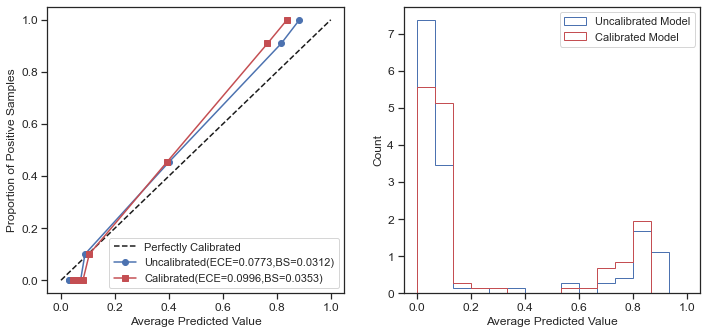

In [181]:
fig, axs = plt.subplots(1, 2, figsize = (11.7,5.27))

# plot perfectly calibrated
axs[0].plot([0, 1], [0, 1], 'k--',label="Perfectly Calibrated")
# plot model uncalibration
axs[0].plot(uncal_mpv, uncal_fop, marker='o', color='b',label="Uncalibrated(ECE={0:0.4f},BS={1:0.4f})".format(uncal_ece,uncal_score_loss))
# plot model reliability
axs[0].plot(cal_mpv, cal_fop, marker='s',color='r',label="Calibrated(ECE={0:0.4f},BS={1:0.4f})".format(cal_ece,cal_score_loss))
axs[0].set_xlabel('Average Predicted Value')
axs[0].set_ylabel('Proportion of Positive Samples')
axs[0].legend()

axs[1].hist(p_pred_prob.ravel(), range=(0, 1), bins=15, color='b',label='Uncalibrated Model', histtype='step',density=True)
axs[1].hist(calibr_sig_xgb_prob.ravel(), range=(0, 1), bins=15,color='r',label='Calibrated Model', histtype='step', density=True)
axs[1].set_xlabel('Average Predicted Value')
axs[1].set_ylabel('Count')
axs[1].legend()
# sns.despine()
plt.savefig("f_result/prob_calibrate_plot_dist.pdf", bbox_inches='tight', pad_inches = 0.1)